In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [2]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation'

In [3]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [4]:
pixels = 256

In [5]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [6]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [7]:
def binarize(img):
    img[img>0] = 1
    return img

In [8]:
def clahe(img):
    clahe = cv2.createCLAHE()
    final_img = np.expand_dims(clahe.apply(img), axis=-1)
    return final_img

In [23]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [24]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(clahe(read_img(path, 'images', masks_name[i])))

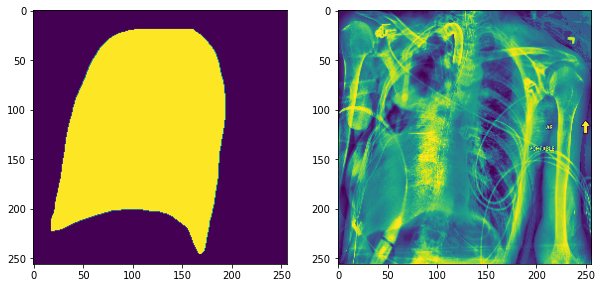

In [45]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [16]:
images.shape

(300, 256, 256, 1)

## Selección de pesos por imagen

Vamos a ver las imagenes y elegir las de peor calidad para darles más peso

In [14]:
# for i in range(len(images)):
#     print(i)
#     plt.figure(figsize=(100, 100))
#     plt.subplot(1,len(images),i+1)
#     plt.imshow(images[i])
#     plt.show()

In [15]:
# bad_quality = [14,15,34] + [i for i in range(39,56)] + [65,73,76,77]

In [16]:
# importance = np.array([1 if i in bad_quality else 0.75 for i in range(len(images))])

# Aumento de datos

In [17]:
import imutils

In [18]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    input_mask = binarize(input_mask)
    return input_image, input_mask

Nuevas imagenes con rotacion random (las tengo que binarizar porque sino al rotar se modifica)

In [19]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [20]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
# importance = np.concatenate((importance, importance), axis=0)

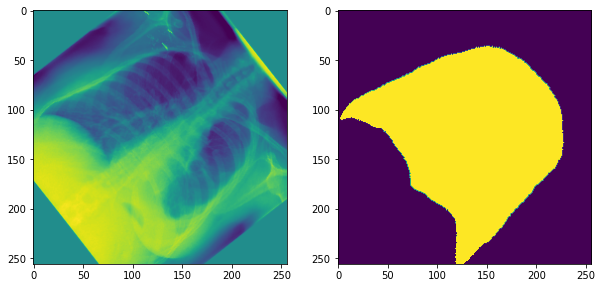

In [21]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [22]:
images.shape

(600, 256, 256, 1)

In [23]:
masks.shape

(600, 256, 256, 1)

In [24]:
np.unique(masks)

array([0., 1.])

# U-Net

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [26]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [27]:
def double_conv_block(x, n_filters):
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with eLU activation
    x = double_conv_block(x, n_filters)
    return x

In [28]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(pixels,pixels,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [29]:
unet_model = build_unet_model()

In [30]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [31]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + 'U-Net1_dice_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

checkpoint_path = "/home/mr1142/Documents/Data/model_weights/" + 'U-Net_dice/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience = 5)

In [32]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [33]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss=dice_coef_loss,
                  metrics=[dice_coef])

In [34]:
batch = 8
epoch = 100

In [35]:
history = unet_model.fit(images,masks,
                         batch_size = batch,
                         epochs = epoch,
                         callbacks = [tensorboard_callback, early_stop],
                         # sample_weight = importance,
                         shuffle = True,
                         validation_split=0.2,
                         verbose = 1)

Epoch 1/100
60/60 [==============================] - 64s 333ms/step - loss: 0.4485 - dice_coef: 0.5515 - val_loss: 0.4371 - val_dice_coef: 0.5629
Epoch 2/100
60/60 [==============================] - 18s 308ms/step - loss: 0.4169 - dice_coef: 0.5831 - val_loss: 0.3303 - val_dice_coef: 0.6697
Epoch 3/100
60/60 [==============================] - 19s 314ms/step - loss: 0.2859 - dice_coef: 0.7141 - val_loss: 0.1950 - val_dice_coef: 0.8050
Epoch 4/100
60/60 [==============================] - 19s 314ms/step - loss: 0.1843 - dice_coef: 0.8157 - val_loss: 0.1584 - val_dice_coef: 0.8416
Epoch 5/100
60/60 [==============================] - 19s 315ms/step - loss: 0.1652 - dice_coef: 0.8348 - val_loss: 0.1425 - val_dice_coef: 0.8575
Epoch 6/100
60/60 [==============================] - 19s 313ms/step - loss: 0.1442 - dice_coef: 0.8558 - val_loss: 0.1315 - val_dice_coef: 0.8685
Epoch 7/100
60/60 [==============================] - 19s 313ms/step - loss: 0.1282 - dice_coef: 0.8718 - val_loss: 0.1310 - 

# Validación

In [36]:
path = '/home/mr1142/Documents/Data/NIH/images_005'

In [37]:
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

In [38]:
pixels = 256

In [39]:
def apply_mask(img, mask):
    img[mask!=1]=0
    return img

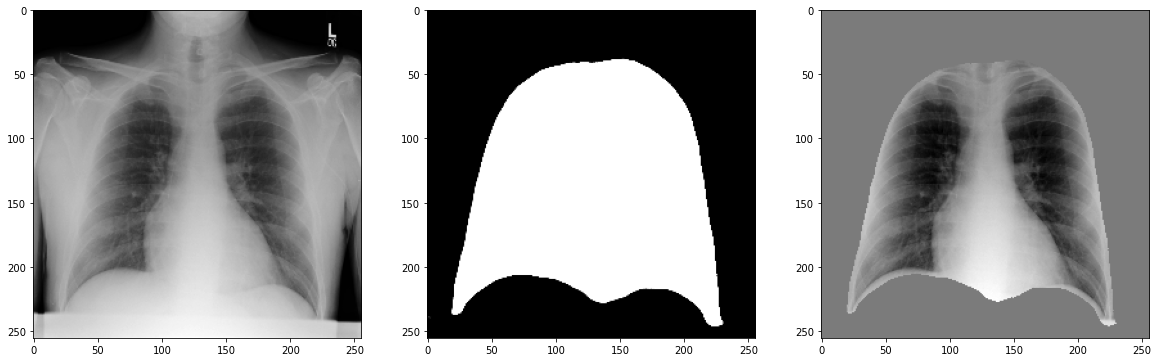

In [66]:
r = np.random.randint(0, len(val_names))
img = normalize(clahe(read_img(path, 'images', val_names[r])))
mask = unet_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

In [67]:
unet_model.save('/home/mr1142/Documents/Data/models/unet_1chan_2.h5')